In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
data=np.load("data.npz")
traindata_x,traindata_y,testdata_x,testdata_y=data['arr_0'],data['arr_1'],data['arr_2'],data['arr_3']
print(traindata_x.shape,traindata_y.shape,testdata_x.shape,testdata_y.shape)
print(traindata_x.dtype,traindata_y.dtype,testdata_x.dtype,testdata_y.dtype)

(10580, 52) (10580,) (21120, 52) (21120,)
float64 int32 float64 int32


In [3]:
#求正常样本的均值和方差，并以此为基准对所有数据做标准化
normal_samples=np.vstack((traindata_x[:500,:],testdata_x[:960,:]))
normal_labels=np.hstack((traindata_y[:500],testdata_y[:960]))
print(np.unique(normal_labels))
print(normal_samples.shape)

mean=np.mean(normal_samples,axis=0)
print(mean.shape,mean)
std=np.std(normal_samples,axis=0)
print(std.shape,std)

#print('origan:',traindata_x[:2,:])
traindata_x2=(traindata_x-mean)/std
testdata_x2=(testdata_x-mean)/std
#print('processed',traindata_x2[:2,:])

[0]
(1460, 52)
(52,) [  2.50552740e-01   3.66219884e+03   4.51115521e+03   9.34419719e+00
   2.69040370e+01   4.23314048e+01   2.70557048e+03   7.50073514e+01
   1.20399925e+02   3.37109432e-01   8.00884740e+01   4.99755822e+01
   2.63433527e+03   2.51636007e+01   4.99697233e+01   3.10275315e+03
   2.29077425e+01   6.58077445e+01   2.32738164e+02   3.41440199e+02
   9.46041801e+01   7.72817096e+01   3.21870507e+01   8.89535233e+00
   2.63963192e+01   6.88255123e+00   1.87724342e+01   1.65560877e+00
   3.29736041e+01   1.38240178e+01   2.39995384e+01   1.25287038e+00
   1.85580863e+01   2.26288384e+00   4.83894397e+00   2.29874521e+00
   1.80560748e-02   8.35738596e-01   9.85035959e-02   5.36895445e+01
   4.38784726e+01   6.30245363e+01   5.39925514e+01   2.46546527e+01
   6.13084164e+01   2.22389240e+01   4.00393473e+01   3.80281699e+01
   4.64639486e+01   4.80833137e+01   4.10995260e+01   1.82237856e+01]
(52,) [  3.01024696e-02   3.38759323e+01   3.64990817e+01   7.86022638e-02
   2.0

0.896539415734
[0.89653941573413765, 24.029732369532045, 65.819791154487547, 1.0279565045668302, 1.8811579179352889, 5.5638191797437813, 478.61055229548663, 14.855833121677694, 24.954151674831035, 1.0470552227072289, 1.9436744498804699, 2.432950621360682, 19.844601105307884, 28.930534099448543, 10.352233514274204, 0.98578593486791088, 1.2289359310400234, 41.114714733961328, 279.33031494071997, 1.1556262698818276, 3.014172580556195, 1.0492646752970702]


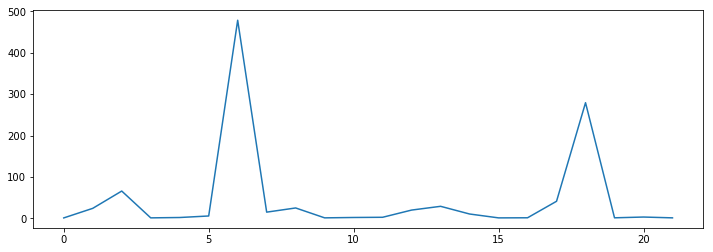

In [4]:
#求每个类别标准化后的norm2，故障和正常数据的norm2有较大差异
norm_0=np.mean(traindata_x2[:500,:]**2)
print(norm_0)
norm=[norm_0]
for i in range(1,22):
    norm_i=np.mean(traindata_x2[500+(i-1)*480:500+i*480,:]**2)
    norm.append(norm_i)
print(norm) 

%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12,4))
plt.plot(norm)
plt.show()

#！！！猜想：norm2大的类别对应的测试准确率要高一些，是否是正相关的？

In [5]:
#训练集中的故障数据前填充20个零向量，使得训练集为(22, 500, 52)

traindata_x_pad=[traindata_x2[:500,:]]
traindata_y_pad=[traindata_y[:500]]
for i in range(1,22):
    data_i=traindata_x2[500+(i-1)*480:500+i*480,:]
    #print(data_i.shape)
    data_i=np.vstack((np.zeros((20,52)),data_i))
    #print(i,data_i.shape)
    label_i=traindata_y[500+(i-1)*480:500+i*480]
    label_i=np.hstack((np.zeros(20,dtype=np.int32),label_i))
    
    traindata_x_pad.append(data_i)
    traindata_y_pad.append(label_i)

traindata_x_pad=np.array(traindata_x_pad)
traindata_y_pad=np.array(traindata_y_pad)
traindata_y_pad=traindata_y_pad.reshape(traindata_y_pad.shape[0],traindata_y_pad.shape[1],-1)
print(traindata_x_pad.shape,traindata_y_pad.shape)

dataset1=np.concatenate((traindata_x_pad,traindata_y_pad),axis=2)
print(dataset1.shape)

(22, 500, 52) (22, 500, 1)
(22, 500, 53)


In [6]:
#reshape测试集，使得训练集为(22, 960, 52)
print(testdata_x2.shape,testdata_y.shape)

testdata_x_pad=testdata_x2.reshape(22,-1,testdata_x2.shape[1])
testdata_y_pad=testdata_y.reshape(22,-1,1)
print(testdata_x_pad.shape,testdata_y_pad.shape)

dataset2=np.concatenate((testdata_x_pad,testdata_y_pad),axis=2)
print(dataset2.shape)

(21120, 52) (21120,)
(22, 960, 52) (22, 960, 1)
(22, 960, 53)


In [7]:
def create_dataset(dataset, look_back=6):
    dataX, dataY = [],[]
    for j in range(dataset.shape[0]):
        for i in range(dataset.shape[1]-look_back):
            a = dataset[j,i:(i + look_back),0:-1]
            dataX.append(a)
            dataY.append(dataset[j,i:(i + look_back),-1])
    
    return np.array(dataX), np.array(dataY,dtype=np.int32)


In [8]:
# 创建好输入输出
train_X, train_Y = create_dataset(dataset1)
test_X, test_Y = create_dataset(dataset2)
print(train_X.shape,train_Y.shape,train_X.dtype,train_Y.dtype)
print(test_X.shape,test_Y.shape,test_X.dtype,test_Y.dtype)

def onehot_encoder(y,cls=22):#y.shape=(n,l)
    
    y_hat=np.zeros((y.shape[0],y.shape[1],cls),dtype=np.int)
    print(y_hat.shape)
    for i in range(y.shape[0]):
        for j in range (y.shape[1]):
            index=int(y[i,j])
            #print(index)
            y_hat[i,j,index]=1
    return y_hat

#x=train_Y[(0,1000,5000),:]
#print(x)
#trainy_hat=onehot_encoder(x)
#print(trainy_hat)

(10868, 6, 52) (10868, 6) float64 int32
(20988, 6, 52) (20988, 6) float64 int32


In [9]:
data_all = np.concatenate((train_X,test_X),axis=0)
label_all = np.concatenate((train_Y,test_Y),axis=0)
print(data_all.shape,label_all.shape)

#重新划分训练集和测试集
from sklearn.cross_validation import train_test_split
train_X,test_X,train_Y,test_Y=train_test_split(data_all, label_all, test_size=0.2, random_state=99) 
print(train_X.shape,test_X.shape,train_Y.shape,test_Y.shape)


(31856, 6, 52) (31856, 6)
(25484, 6, 52) (6372, 6, 52) (25484, 6) (6372, 6)


/home/zqq/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
#转换成Tensor
train_x = (torch.from_numpy(train_X)).float()
train_y = torch.from_numpy(train_Y).long()
test_x = (torch.from_numpy(test_X)).float()
test_y = torch.from_numpy(test_Y).long()
print(train_x.dtype,train_x.size())
print(test_x.dtype,test_x.size())
print(train_y.dtype,train_y.size())
print(test_y.dtype,test_y.size())

torch.float32 torch.Size([25484, 6, 52])
torch.float32 torch.Size([6372, 6, 52])
torch.int64 torch.Size([25484, 6])
torch.int64 torch.Size([6372, 6])


In [11]:
# 先转换成 torch 能识别的 Dataset
import torch.utils.data as Data

train_dataset = Data.TensorDataset(train_x,train_y)
# 把 dataset 放入 DataLoader
train_loader = Data.DataLoader(
    dataset=train_dataset,      # torch TensorDataset format
    batch_size=64,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
)
test_dataset = Data.TensorDataset(test_x,test_y)
# 把 dataset 放入 DataLoader
test_loader = Data.DataLoader(
    dataset=test_dataset,      # torch TensorDataset format
    batch_size=64,      # mini batch size
    #shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

cuda:0


In [13]:
from collections import OrderedDict

class Sparse_autoencoder(nn.Module):
    def __init__(self, input_size=52, embedding_size=30, output_size=22, device=device):
        super(Sparse_autoencoder,self).__init__()
        self.input_size=input_size
        self.embedding_size=embedding_size
        self.output_size=output_size
        self.device=device
        
        self.dropout = nn.Dropout(p=0.2)  #1/(1-p)
        self.encoder=nn.Sequential(OrderedDict([
                    ('sparse1',nn.Linear(self.input_size, self.input_size)),
                    ('action1',nn.Tanh()),
                    ('sparse2',nn.Linear(self.input_size, self.embedding_size)),
                    ('action2',nn.Tanh())
                    ]))
        self.decoder=nn.Sequential(OrderedDict([
                    ('fc1',nn.Linear(self.embedding_size, self.input_size)),
                    ('action3',nn.Tanh()),
                    ('fc2',nn.Linear(self.input_size, self.input_size))
                    ]))
        self.reg = nn.Linear(self.embedding_size, self.output_size)
        
    def init_weights(self, initrange=0.2):
        """Initialize weights."""
        self.encoder.sparse1.weight.data.uniform_(-initrange, initrange)
        self.encoder.sparse1.bias.data.uniform_(-initrange, initrange)
        self.encoder.sparse2.weight.data.uniform_(-initrange, initrange)
        self.encoder.sparse2.bias.data.uniform_(-initrange, initrange) 
        self.decoder.fc1.weight.data.uniform_(-initrange, initrange)
        self.decoder.fc1.bias.data.uniform_(-initrange, initrange)
        self.decoder.fc2.weight.data.uniform_(-initrange, initrange)
        self.decoder.fc2.bias.data.uniform_(-initrange, initrange)
        self.reg.weight.data.uniform_(-initrange, initrange)
        self.reg.bias.data.uniform_(-initrange, initrange)
        
    def forward(self, x): 
        b, l, h = x.shape  #(batch, seq, hidden)
        x = x.contiguous().view(l*b,-1) 
        e = self.encoder(self.dropout(x))
        x_bar = self.decoder(e)
        #out = self.reg(self.dropout(e))
        out = self.reg(e)
        x_bar = x_bar.contiguous().view(b,l,-1)
        
        return x_bar,e,out
    
    def load_model(self, load_dir):
        if self.device.type == 'cuda':
            self.load_state_dict(torch.load(open(load_dir, 'rb')))
        else:
            self.load_state_dict(torch.load(open(load_dir, 'rb'), map_location=lambda storage, loc: storage))

    def save_model(self, save_dir):
        torch.save(self.state_dict(), open(save_dir, 'wb'))
        
Sparse_AE = Sparse_autoencoder(device=device)
Sparse_AE.to(device)
Loss_MSE = nn.MSELoss()
Loss_CE = nn.CrossEntropyLoss()
optimizer_SparseAE = torch.optim.SGD(Sparse_AE.parameters(), lr=1e-3,momentum=0.9)
              

In [14]:
#稀疏编码器加L1约束
def L1_penalty(param, debug=False):
    if isinstance(param, torch.Tensor):
        param= [param]
    total_L1_norm=0
    for p in filter(lambda p: p.data is not None, param):
        param_norm = p.data.norm(p=1) 
        if debug:print('param_norm',param_norm)
        total_L1_norm += param_norm
        if debug:print('L1',total_L1_norm)
        
    return total_L1_norm

test=torch.tensor([[[-1.0,-2.0],
                   [1.0,2.0]],
                   [[-1.0,-2.0],
                   [1.0,2.0]]])
print(test.shape)
print(L1_penalty(test,debug=True))

torch.Size([2, 2, 2])
param_norm tensor(12.)
L1 tensor(12.)
tensor(12.)


In [15]:
def val_AE(net,test_loader,lambd1,lambd2):
    Losses=[]
    Acces=[]
    Acc=[0]*22 
    Det=[0]*22
    Total=[0]*22
    #net.eval()
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(test_loader):
          #if step<3:
            batch_x=batch_x.to(device)
            batch_y=batch_y.to(device)
            batch_y=batch_y.view(-1)
            
            x_bar,embedding,out = net(batch_x)
            Loss_L1_penalty = lambd1 * L1_penalty(embedding)
            loss_L2 = Loss_MSE(x_bar,batch_x)            
            loss_CE = lambd2 * Loss_CE(out,batch_y)
            loss = loss_L2 + Loss_L1_penalty + loss_CE
            total = batch_y.size(0)
            Losses.append(loss.item()/total)
            
            out=F.softmax(out,1)
            _,index=out.max(dim=1)
            acc=(index==batch_y).sum().cpu().numpy() 
            Acces.append(acc/total)
            
              #按类别统计正确率
            for i in range(batch_y.shape[0]):
                Total[batch_y[i]]+=1
                if index[i]==batch_y[i]:
                    Acc[batch_y[i]]+=1
                if (index[i]>0)==(batch_y[i]>0):
                    Det[batch_y[i]]+=1
    for i in range(22):
        Acc[i]/=Total[i]
        Det[i]/=Total[i]
   
        #print(Losses)
    return np.mean(Losses),np.mean(Acces),Acc,Det

#Loss,ACC = val_AE(net,test_loader)   
#print(Loss)

In [16]:
#开始训练
train_Loss=[]
test_Loss=[]
train_Acc=[]
test_Acc=[]

allclass_acc=[]
alldet_acc=[]

def train(net, train_lodader, optimizer, lambd1=1e-4, lambd2=100, epoch=200):
    net.init_weights()
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.5)
    #net.to(device)
    for e in range(epoch):
        Losses=[]
        Acces=[]
        for step, (batch_x, batch_y) in enumerate(train_loader):
          #if step<300:  
            scheduler.step()
            optimizer.zero_grad()
            batch_x=batch_x.to(device)    
            batch_y=batch_y.to(device)
            batch_y=batch_y.view(-1)
            
            x_bar,embedding,out = net(batch_x)            
            Loss_L1_penalty = lambd1* L1_penalty(embedding)
            loss_L2 = Loss_MSE(x_bar,batch_x)
            loss_CE = lambd2 * Loss_CE(out,batch_y)
            
            loss = loss_L2 + Loss_L1_penalty + loss_CE
            if step==0 and (e+1)%10==0:
                print(loss_L2,Loss_L1_penalty,loss_CE,loss)

            #反向传播      
            loss.backward()
            optimizer.step()

            total = batch_y.size(0)
            Losses.append(loss.item()/total)
            
            out=F.softmax(out,1)
            _,index=out.max(dim=1)
            acc=(index==batch_y).sum().cpu().numpy()       
            Acces.append(acc/total)
            
        #print(Losses,Acces)        
        if e==0: print('Epoch:0, TrainLoss:{:.5f},'.format(Losses[0]))
        Loss,Acc,ACC,Det=val_AE(Sparse_AE,test_loader,lambd1=lambd1,lambd2=lambd2)
        test_Loss.append(Loss)
        train_Loss.append(np.mean(Losses))
        test_Acc.append(Acc)
        train_Acc.append(np.mean(Acces))
        allclass_acc.append(ACC)
        alldet_acc.append(Det)
        print('Epoch:{}, TrainLoss:{:.5f}, TestLoss:{:.5f}, TrainAcc:{:.5f}, TestAcc:{:.5f},'.format(e+1, np.mean(Losses),Loss,np.mean(Acces), Acc ))     
    
train(Sparse_AE,train_loader,optimizer_SparseAE)


Epoch:0, TrainLoss:0.91296,
Epoch:1, TrainLoss:0.59019, TestLoss:0.51648, TrainAcc:0.50265, TestAcc:0.56622,
Epoch:2, TrainLoss:0.49025, TestLoss:0.47414, TrainAcc:0.58961, TestAcc:0.60229,
Epoch:3, TrainLoss:0.46270, TestLoss:0.44581, TrainAcc:0.61246, TestAcc:0.62229,
Epoch:4, TrainLoss:0.43340, TestLoss:0.42678, TrainAcc:0.62913, TestAcc:0.63584,
Epoch:5, TrainLoss:0.41708, TestLoss:0.40792, TrainAcc:0.64108, TestAcc:0.64843,
Epoch:6, TrainLoss:0.39962, TestLoss:0.39398, TrainAcc:0.65190, TestAcc:0.65767,
Epoch:7, TrainLoss:0.39037, TestLoss:0.38569, TrainAcc:0.65865, TestAcc:0.66087,
Epoch:8, TrainLoss:0.37653, TestLoss:0.36990, TrainAcc:0.66545, TestAcc:0.67310,
Epoch:9, TrainLoss:0.36672, TestLoss:0.35913, TrainAcc:0.67133, TestAcc:0.67731,
tensor(27.0210, device='cuda:0') tensor(0.9394, device='cuda:0') tensor(106.1294, device='cuda:0') tensor(134.0897, device='cuda:0')
Epoch:10, TrainLoss:0.36123, TestLoss:0.35450, TrainAcc:0.67370, TestAcc:0.67712,
Epoch:11, TrainLoss:0.35178,

Epoch:88, TrainLoss:0.27171, TestLoss:0.27080, TrainAcc:0.70674, TestAcc:0.70905,
Epoch:89, TrainLoss:0.27026, TestLoss:0.26910, TrainAcc:0.70613, TestAcc:0.71026,
tensor(8.2052, device='cuda:0') tensor(0.9676, device='cuda:0') tensor(78.4314, device='cuda:0') tensor(87.6043, device='cuda:0')
Epoch:90, TrainLoss:0.26972, TestLoss:0.27211, TrainAcc:0.70765, TestAcc:0.70480,
Epoch:91, TrainLoss:0.27470, TestLoss:0.26881, TrainAcc:0.70192, TestAcc:0.71109,
Epoch:92, TrainLoss:0.27234, TestLoss:0.27145, TrainAcc:0.70653, TestAcc:0.70652,
Epoch:93, TrainLoss:0.26903, TestLoss:0.27078, TrainAcc:0.70719, TestAcc:0.70867,
Epoch:94, TrainLoss:0.26864, TestLoss:0.27436, TrainAcc:0.70911, TestAcc:0.70477,
Epoch:95, TrainLoss:0.27121, TestLoss:0.27263, TrainAcc:0.70681, TestAcc:0.70588,
Epoch:96, TrainLoss:0.26951, TestLoss:0.27053, TrainAcc:0.70750, TestAcc:0.70915,
Epoch:97, TrainLoss:0.26898, TestLoss:0.27293, TrainAcc:0.70676, TestAcc:0.70392,
Epoch:98, TrainLoss:0.27074, TestLoss:0.26920, Tra

Epoch:173, TrainLoss:0.26168, TestLoss:0.26828, TrainAcc:0.71263, TestAcc:0.71011,
Epoch:174, TrainLoss:0.26175, TestLoss:0.26428, TrainAcc:0.71227, TestAcc:0.71194,
Epoch:175, TrainLoss:0.26166, TestLoss:0.26130, TrainAcc:0.71334, TestAcc:0.71269,
Epoch:176, TrainLoss:0.26306, TestLoss:0.26188, TrainAcc:0.71144, TestAcc:0.71333,
Epoch:177, TrainLoss:0.26165, TestLoss:0.25959, TrainAcc:0.71129, TestAcc:0.71513,
Epoch:178, TrainLoss:0.26293, TestLoss:0.26215, TrainAcc:0.71155, TestAcc:0.71357,
Epoch:179, TrainLoss:0.26267, TestLoss:0.26691, TrainAcc:0.71104, TestAcc:0.70888,
tensor(5.0174, device='cuda:0') tensor(0.9753, device='cuda:0') tensor(87.8182, device='cuda:0') tensor(93.8109, device='cuda:0')
Epoch:180, TrainLoss:0.26101, TestLoss:0.26598, TrainAcc:0.71277, TestAcc:0.71155,
Epoch:181, TrainLoss:0.26131, TestLoss:0.26332, TrainAcc:0.71417, TestAcc:0.71223,
Epoch:182, TrainLoss:0.26102, TestLoss:0.26035, TrainAcc:0.71300, TestAcc:0.71349,
Epoch:183, TrainLoss:0.26165, TestLoss:0

In [23]:
print("classication_acc",allclass_acc[-1])
print("det_acc",alldet_acc[-1])
k=[1,2,4,5,6,7,8,10,11,12,13,14,16,17,18,19,20]
det=[]
for i in k:
    det.append(alldet_acc[i])
det_mean=np.mean(np.array(det))
print("mean",det_mean)

classication_acc [0.7842532467532467, 0.9613848202396804, 0.9724647414372062, 0.21664275466284075, 0.7860892388451444, 0.7579075425790754, 0.9936265137029955, 0.8147157190635451, 0.8859756097560976, 0.02435897435897436, 0.6249205340114431, 0.6172761664564943, 0.7673634524612273, 0.8291525423728814, 0.8797385620915033, 0.04217687074829932, 0.5953795379537954, 0.7865961199294532, 0.809555408095554, 0.702491103202847, 0.6820728291316527, 0.8938053097345132]
det_acc [0.7842532467532467, 0.9980026631158455, 0.9879113498992612, 0.4483500717360115, 0.8595800524934383, 0.8880778588807786, 0.9980879541108987, 0.9645484949832775, 0.9908536585365854, 0.3858974358974359, 0.8855689764780674, 0.8644388398486759, 0.9885367498314228, 0.9661016949152542, 0.9758169934640523, 0.34285714285714286, 0.8706270627062707, 0.9412110523221634, 0.9024552090245521, 0.8263345195729538, 0.8508403361344538, 0.9222503160556258]
mean 0.795947539848


0.71982349537


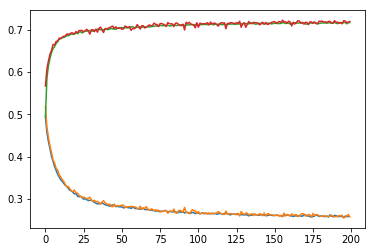

In [22]:
#迭代200次, lambd=1e-5
print(test_Acc[-1])
plt.plot(train_Loss[1:])
plt.plot(test_Loss)
plt.plot(train_Acc)
plt.plot(test_Acc)
plt.show()

In [33]:
Sparse_AE.save_model("SparseAE_nodropout_epoch200.pth")

In [ ]:
Sparse_AE.load_model("SparseAE_epoch200.pth")


In [34]:
test_seq_x,test_seq_y=test_dataset[100:120]
print(test_seq_y)
Embedding = Sparse_AE.encoder(test_seq_x.cuda())
print(Embedding.shape,Embedding[0,:,:])

tensor([[ 17,  17,  17,  17,  17,  17],
        [ 18,  18,  18,  18,  18,  18],
        [  2,   2,   2,   2,   2,   2],
        [ 21,  21,  21,  21,  21,  21],
        [ 18,  18,  18,  18,  18,  18],
        [ 18,  18,  18,  18,  18,  18],
        [ 15,  15,  15,  15,  15,  15],
        [  8,   8,   8,   8,   8,   8],
        [  8,   8,   8,   8,   8,   8],
        [  1,   1,   1,   1,   1,   1],
        [ 11,  11,  11,  11,  11,  11],
        [ 10,  10,  10,  10,  10,  10],
        [  6,   6,   6,   6,   6,   6],
        [  1,   1,   1,   1,   1,   1],
        [ 20,  20,  20,  20,  20,  20],
        [  9,   9,   9,   9,   9,   9],
        [  0,   0,   0,   0,   0,   0],
        [  8,   8,   8,   8,   8,   8],
        [ 17,  17,  17,  17,  17,  17],
        [ 10,  10,  10,  10,  10,  10]])
torch.Size([20, 6, 30]) tensor([[-0.9937, -0.9740, -0.9994,  0.3390,  0.9932, -0.8744,  0.4497,
          0.7729,  0.9829, -0.9986,  1.0000,  1.0000,  0.1256, -0.9487,
         -0.7550, -0.9999, -0.9

In [35]:
print((Embedding==0).sum().float()/(20*6*200))

tensor(0., device='cuda:0')
